# ResNext `pretrained=False` (LSTM) Model Deepfakedetection Celeb-DF with No Transformed Data Added

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
# Device configuration (GPU, MPS, or CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import seaborn as sns
import torchvision.transforms as transforms


In [4]:
# Define paths
PARENT_PATH_FAKE = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake'
PARENT_PATH_REAL = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_real'
TRANSFORMED_PATH_FAKE = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/transformed/celebdf_fake'
TRANSFORMED_PATH_REAL = '/Users/faishalkamil/Downloads/documents skripsi/extracted frames/transformed/celebdf_real'

# Define folders to use
REAL_FOLDERS = [
    'id0_0007_faces', 'id1_0001_faces', 'id1_0002_faces', 'id1_0005_faces', 'id1_0008_faces',
    'id2_0007_faces', 'id2_0001_faces', 'id5_0001_faces', 'id5_0004_faces', 'id5_0005_faces',
    'id5_0009_faces', 'id7_0000_faces', 'id7_0001_faces', 'id7_0008_faces', 'id8_0005_faces',
    'id9_0001_faces', 'id9_0004_faces', 'id10_0002_faces', 'id10_0005_faces', 'id11_0001_faces',
    'id12_0002_faces', 'id13_0003_faces', 'id16_0009_faces', 'id19_0003_faces', 'id22_0004_faces',
    'id23_0001_faces', 'id25_0006_faces', 'id25_0009_faces', 'id27_0009_faces', 'id29_0007_faces',
    'id35_0003_faces', 'id35_0006_faces', 'id35_0009_faces', 'id37_0002_faces', 'id39_0001_faces'
]

FAKE_FOLDERS = [
    'id0_id9_0007_faces', 'id0_id16_0008_faces', 'id0_id17_0007_faces', 'id1_id2_0001_faces',
    'id1_id16_0005_faces', 'id2_id0_0002_faces', 'id2_id1_0008_faces', 'id2_id3_0009_faces',
    'id2_id17_0008_faces', 'id2_id23_0009_faces', 'id2_id26_0006_faces', 'id3_id35_0004_faces',
    'id4_id0_0008_faces', 'id4_id1_0008_faces', 'id4_id3_0007_faces', 'id4_id9_0003_faces',
    'id4_id20_0008_faces', 'id4_id30_0005_faces', 'id4_id37_0003_faces', 'id6_id9_0000_faces',
    'id6_id9_0002_faces', 'id6_id9_0006_faces', 'id6_id23_0005_faces', 'id6_id26_0001_faces',
    'id6_id26_0005_faces', 'id7_id10_0001_faces', 'id7_id12_0000_faces', 'id7_id13_0004_faces',
    'id8_id9_0007_faces', 'id9_id6_0004_faces', 'id9_id26_0001_faces', 'id10_id11_0005_faces',
    'id10_id13_0003_faces', 'id10_id13_0005_faces', 'id13_id7_0003_faces'
]

In [5]:
class DeepFakeDataset(Dataset):
    def __init__(self, parent_path_fake, parent_path_real, fake_folders, real_folders):
        self.data = []

        # Load fake data
        for folder in fake_folders:
            folder_path = os.path.join(parent_path_fake, folder)
            frames = [os.path.join(folder_path, frame) for frame in os.listdir(folder_path) if frame.endswith('.jpg')]
            self.data.extend([(frame, 1) for frame in frames])
            print(f"Loaded {len(frames)} fake frames from {folder_path}")  # Debug statement

        # Load real data
        for folder in real_folders:
            folder_path = os.path.join(parent_path_real, folder)
            frames = [os.path.join(folder_path, frame) for frame in os.listdir(folder_path) if frame.endswith('.jpg')]
            self.data.extend([(frame, 0) for frame in frames])
            print(f"Loaded {len(frames)} real frames from {folder_path}")  # Debug statement

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        frame = Image.open(frame_path).convert('RGB')  # Load image using PIL
        frame = transforms.ToTensor()(frame)  # Convert image to tensor
        return frame, label

# Initialize the dataset
dataset = DeepFakeDataset(parent_path_fake=PARENT_PATH_FAKE, parent_path_real=PARENT_PATH_REAL, fake_folders=FAKE_FOLDERS, real_folders=REAL_FOLDERS)

# Check the length of the dataset
print(f"Total samples in dataset: {len(dataset)}")  # Should be greater than 0


Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id0_id9_0007_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id0_id16_0008_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id0_id17_0007_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id1_id2_0001_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id1_id16_0005_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id2_id0_0002_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id2_id1_0008_faces
Loaded 148 fake frames from /Users/faishalkamil/Downloads/documents skripsi/extracted frames/celebdf_fake/id2_id3_0009_fac

In [6]:
# Split the dataset into train, test, and validation
if len(dataset) > 0:
    train_size = int(0.7 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Print the number of images in each set
    print(f"Number of frames (images) in the training set: {len(train_dataset)}")
    print(f"Number of frames (images) in the validation set: {len(val_dataset)}")
    print(f"Number of frames (images) in the test set: {len(test_dataset)}")
    
    print("DataLoaders created successfully.")
else:
    print("Dataset is empty. Please check the paths and loading logic.")


Number of frames (images) in the training set: 7226
Number of frames (images) in the validation set: 2064
Number of frames (images) in the test set: 1034
DataLoaders created successfully.


In [7]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [8]:
# Define the Model: ResNeXt50 + LSTM
class DeepFakeDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepFakeDetectionModel, self).__init__()
        self.base_model = models.resnext50_32x4d(pretrained=False)
        self.base_model.fc = nn.Identity()  # Remove the final FC layer
        self.lstm = nn.LSTM(2048, 512, batch_first=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # Check if input has 4 or 5 dimensions
        if len(x.size()) == 4:
            # Input shape is (batch_size, c, h, w) - Single frame input
            x = x.unsqueeze(1)  # Add a sequence length dimension: (batch_size, 1, c, h, w)

        batch_size, seq_len, c, h, w = x.size()
        
        x = x.view(batch_size * seq_len, c, h, w)  # Reshape for ResNeXt input
        features = self.base_model(x)
        features = features.view(batch_size, seq_len, -1)  # (Batch, Sequence, Features)
        lstm_out, _ = self.lstm(features)
        lstm_out = lstm_out[:, -1, :]  # Take only the output from the last LSTM cell
        out = self.classifier(lstm_out)
        return out


## 10 epc, lr = 0.0001

In [9]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=10):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0   

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [11]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=10):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [12]:
def test_model_with_samples_last_frames(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_inputs = []  # Store all input frames for final selection

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels, predictions, and inputs for post-loop processing
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_inputs.extend(inputs.cpu())  # Store frames in CPU memory

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="#FF6F61", lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color="#6B5B95", lw=2, linestyle='--', label='Random Guess')
    plt.fill_between(fpr, tpr, color="#FFA07A", alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')
    plt.show()

    # Select last 3 frames for each class (Real and Fake) based on final predictions
    real_samples = [all_inputs[i] for i in range(len(all_labels)) if all_preds[i] == 0][-3:]
    fake_samples = [all_inputs[i] for i in range(len(all_labels)) if all_preds[i] == 1][-3:]

    # Display 3 frames from each class (Real and Fake) from the last occurrences
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Sample Frames (Last 3 Frames from Dataloader): Real Class (Top) and Fake Class (Bottom)', fontsize=16, weight = 'bold')

    for i in range(3):
        if i < len(real_samples):
            axes[0, i].imshow(real_samples[i].permute(1, 2, 0).numpy())
            axes[0, i].axis('off')
            axes[0, i].set_title("Real")

        if i < len(fake_samples):
            axes[1, i].imshow(fake_samples[i].permute(1, 2, 0).numpy())
            axes[1, i].axis('off')
            axes[1, i].set_title("Fake")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust to fit the title
    plt.show()

    return test_loss, test_acc


In [14]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch):
    epochs = range(1, num_epoch + 1)

    # Create the figure and subplots for loss and accuracy
    plt.figure(figsize=(12, 5))

    # Define more vibrant colors for better visibility
    train_loss_color = '#1f77b4'  
    val_loss_color = '#ff7f0e'    
    train_acc_color = '#1f77b4'   
    val_acc_color = '#ff7f0e'     
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color=train_loss_color, linestyle='-', label='Training Loss')
    plt.plot(epochs, val_losses, marker='o', color=val_loss_color, linestyle='-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0.0, max(max(train_losses), max(val_losses)) * 1.1)  # Set y-axis limits for loss
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color=train_acc_color, linestyle='-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, marker='o', color=val_acc_color, linestyle='-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Adjust layout for better spacing between subplots
    plt.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [15]:
# Run training for 10 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=10)

Epoch 1/10, Train Loss: 0.3946, Train Accuracy: 0.8186
Epoch 2/10, Train Loss: 0.1915, Train Accuracy: 0.9231
Epoch 3/10, Train Loss: 0.1375, Train Accuracy: 0.9514
Epoch 4/10, Train Loss: 0.0959, Train Accuracy: 0.9654
Epoch 5/10, Train Loss: 0.0727, Train Accuracy: 0.9745
Epoch 6/10, Train Loss: 0.0642, Train Accuracy: 0.9777
Epoch 7/10, Train Loss: 0.0605, Train Accuracy: 0.9794
Epoch 8/10, Train Loss: 0.0373, Train Accuracy: 0.9875
Epoch 9/10, Train Loss: 0.0415, Train Accuracy: 0.9864
Epoch 10/10, Train Loss: 0.0324, Train Accuracy: 0.9902
Training complete.


In [16]:
# Run validation for 10 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=10)

Epoch 1/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 2/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 3/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 4/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 5/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 6/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 7/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 8/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 9/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Epoch 10/10, Validation Loss: 0.0337, Validation Accuracy: 0.9922
Validation complete.


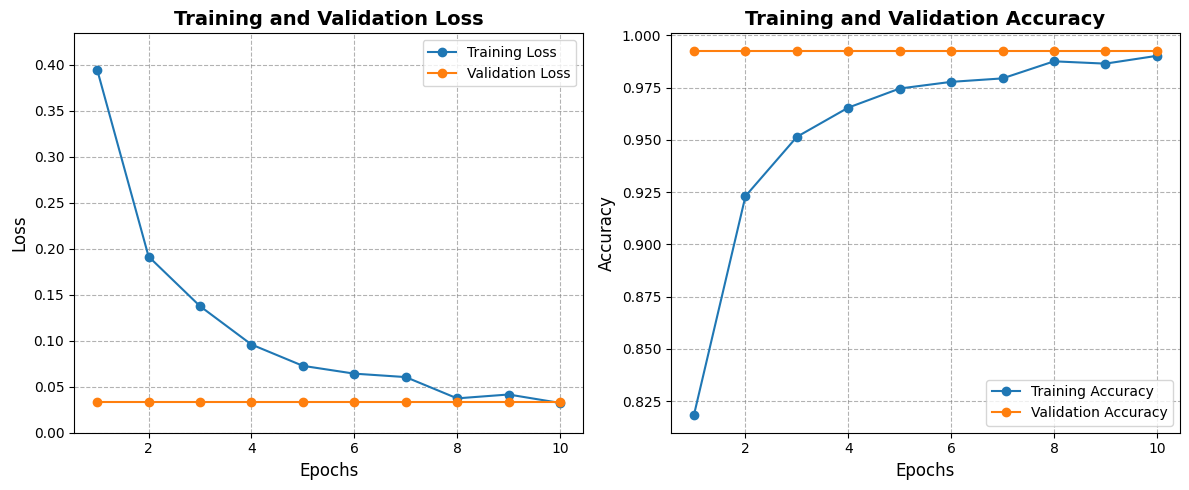

In [17]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=10)

Test Loss: 0.0296, Test Accuracy: 0.9923
Confusion Matrix:
[[514   6]
 [  2 512]]


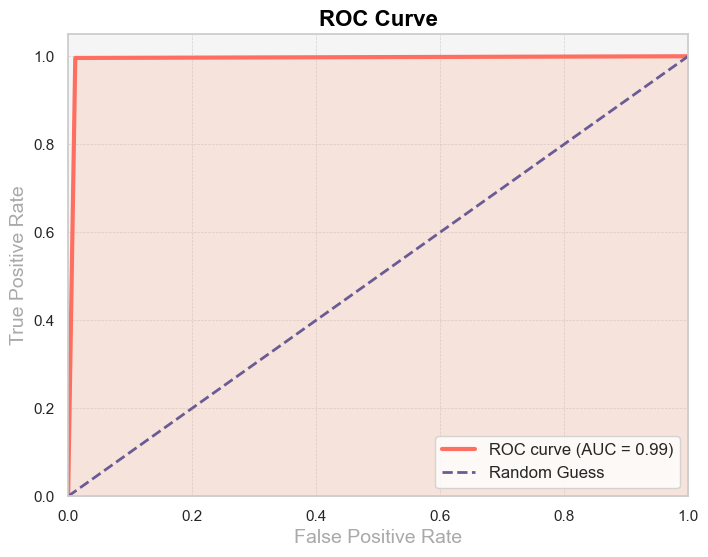

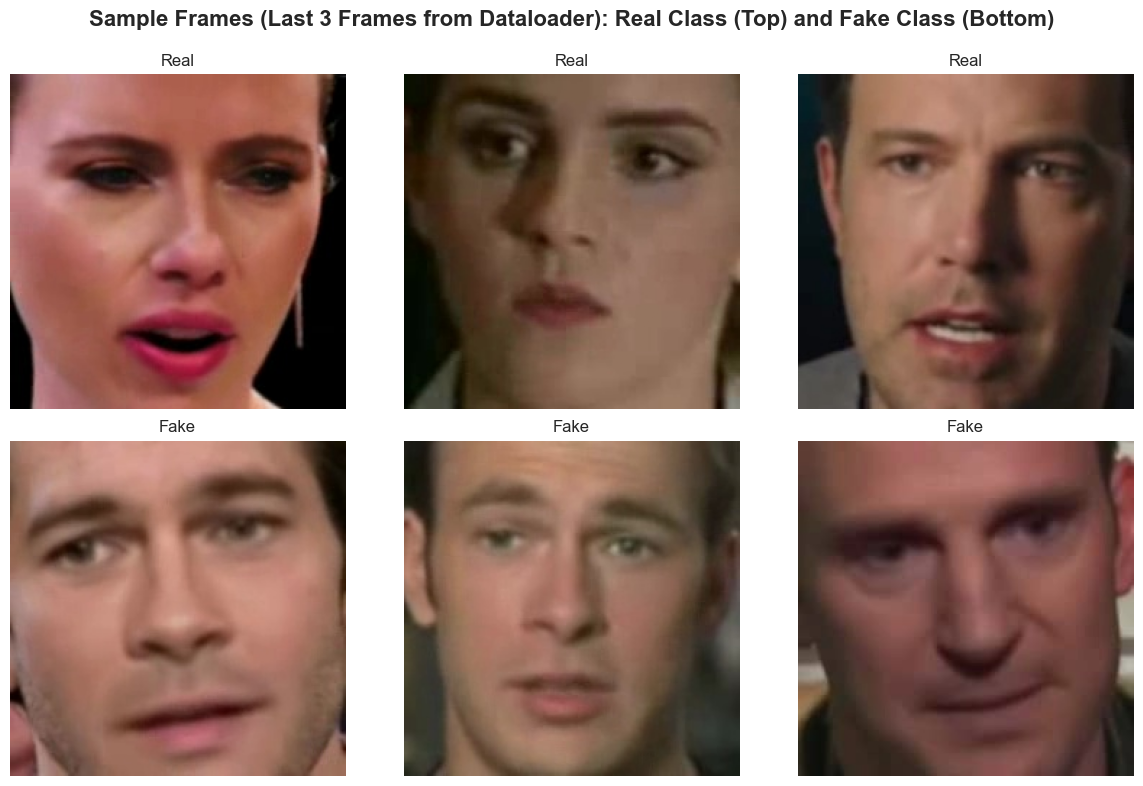

In [18]:
test_loss, test_acc = test_model_with_samples_last_frames(model, test_loader, criterion, device)

Test Loss: 0.0816, Test Accuracy: 0.9729
Confusion Matrix:
[[521   2]
 [ 26 485]]


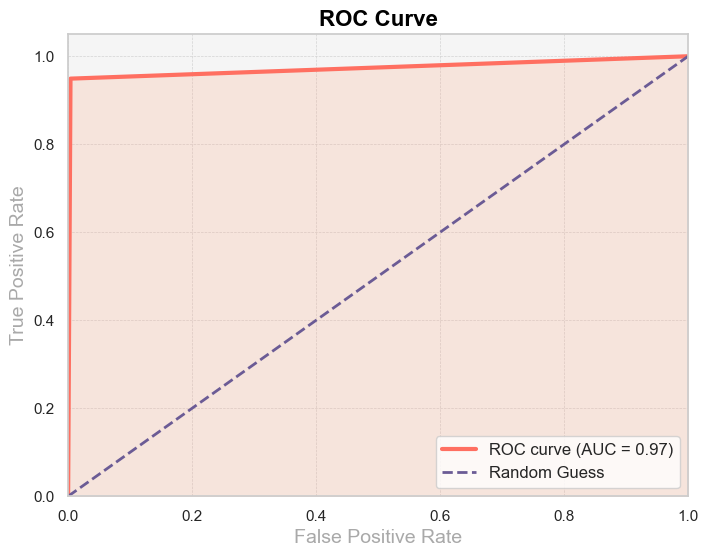

In [18]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

In [19]:
model.to(device)  # Move the model back to the MPS device

DeepFakeDetectionModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

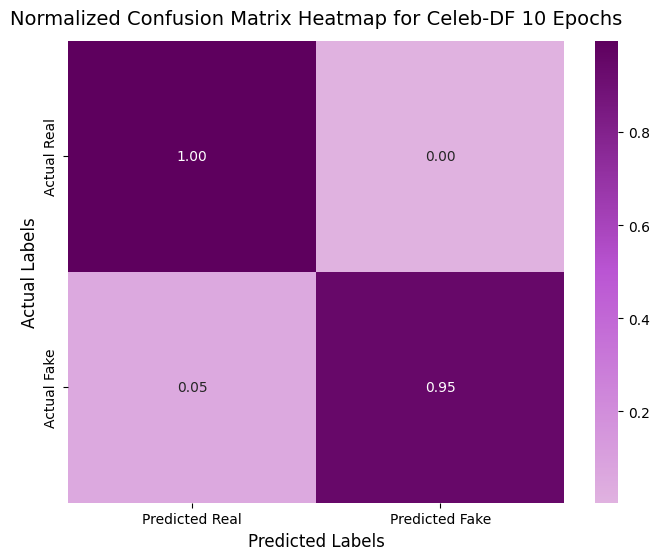

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[521, 2],  # Actual Real
                               [26, 485]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark mediumorchid
cmap = LinearSegmentedColormap.from_list("custom_orchid", ["#e0b2e0", "mediumorchid", "#5e005e"])  # Light to dark mediumorchid

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Celeb-DF 10 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()


updated

## 10 epc, lr = 0.01

In [9]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=10):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [12]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=10):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [13]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [14]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch):
    epochs = range(1, num_epoch + 1)

    # Create the figure and subplots for loss and accuracy
    plt.figure(figsize=(12, 5))

    # Define more vibrant colors for better visibility
    train_loss_color = '#1f77b4'  
    val_loss_color = '#ff7f0e'    
    train_acc_color = '#1f77b4'   
    val_acc_color = '#ff7f0e'     
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', color=train_loss_color, linestyle='-', label='Training Loss')
    plt.plot(epochs, val_losses, marker='o', color=val_loss_color, linestyle='-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0.0, max(max(train_losses), max(val_losses)) * 1.1)  # Set y-axis limits for loss
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', color=train_acc_color, linestyle='-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, marker='o', color=val_acc_color, linestyle='-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', color='gray', alpha=0.6)

    # Adjust layout for better spacing between subplots
    plt.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [15]:
# Run training for 10 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=10)

Epoch 1/10, Train Loss: 0.7527, Train Accuracy: 0.5202
Epoch 2/10, Train Loss: 0.7441, Train Accuracy: 0.5259
Epoch 3/10, Train Loss: 0.7338, Train Accuracy: 0.5307
Epoch 4/10, Train Loss: 0.7537, Train Accuracy: 0.5014
Epoch 5/10, Train Loss: 0.7449, Train Accuracy: 0.5030
Epoch 6/10, Train Loss: 0.7544, Train Accuracy: 0.4950
Epoch 7/10, Train Loss: 0.7297, Train Accuracy: 0.4923
Epoch 8/10, Train Loss: 0.7478, Train Accuracy: 0.4989
Epoch 9/10, Train Loss: 0.7523, Train Accuracy: 0.4895
Epoch 10/10, Train Loss: 0.7466, Train Accuracy: 0.5091
Training complete.


In [16]:
# Run validation for 10 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=10)

Epoch 1/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 2/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 3/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 4/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 5/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 6/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 7/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 8/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 9/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Epoch 10/10, Validation Loss: 0.7093, Validation Accuracy: 0.5111
Validation complete.


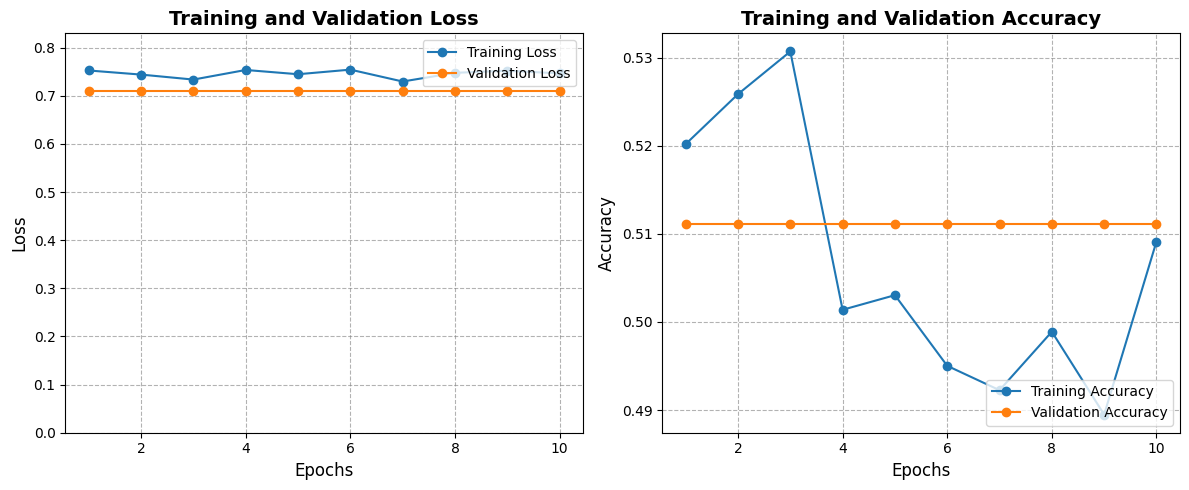

In [17]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=10)

Test Loss: 0.7063, Test Accuracy: 0.5184
Confusion Matrix:
[[536   0]
 [498   0]]


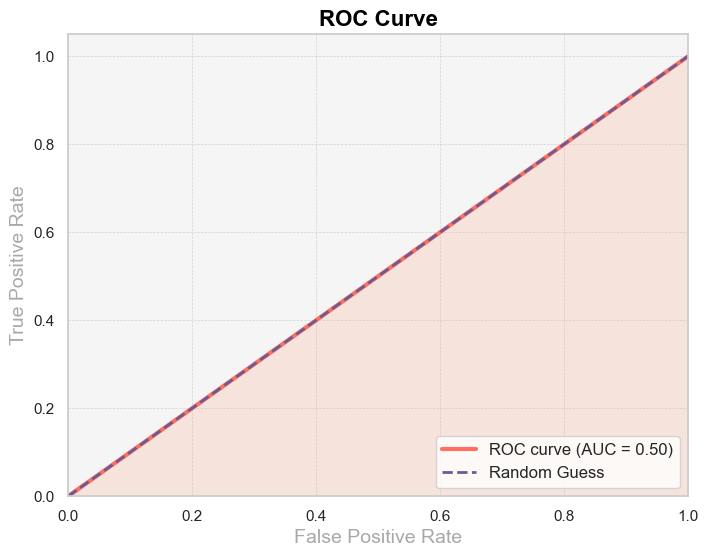

In [18]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

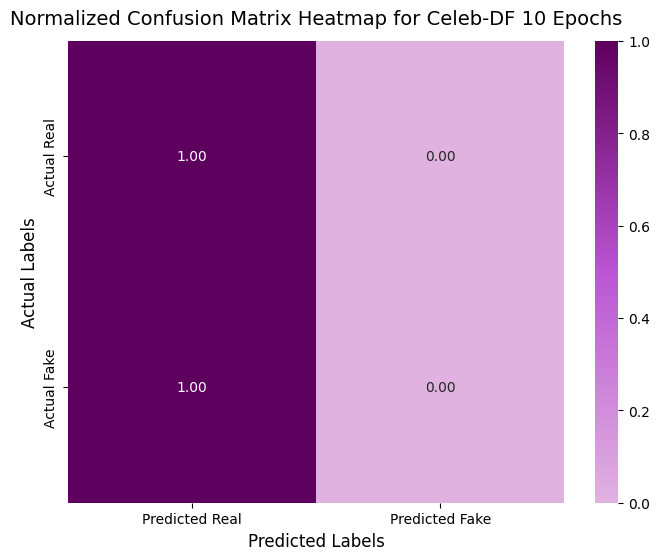

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[536, 0],  # Actual Real
                               [498, 0]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from light to dark mediumorchid
cmap = LinearSegmentedColormap.from_list("custom_orchid", ["#e0b2e0", "mediumorchid", "#5e005e"])  # Light to dark mediumorchid

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Celeb-DF 10 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 15 epc, lr = 0.01

In [20]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [22]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=15):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [23]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=15):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [24]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [25]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
# Run training for 15 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=15)

Epoch 1/15, Train Loss: 0.7477, Train Accuracy: 0.5329
Epoch 2/15, Train Loss: 0.7366, Train Accuracy: 0.5210
Epoch 3/15, Train Loss: 0.7902, Train Accuracy: 0.5010
Epoch 4/15, Train Loss: 0.7491, Train Accuracy: 0.4964
Epoch 5/15, Train Loss: 0.7615, Train Accuracy: 0.4967
Epoch 6/15, Train Loss: 0.8071, Train Accuracy: 0.4997
Epoch 7/15, Train Loss: 0.7742, Train Accuracy: 0.4958
Epoch 8/15, Train Loss: 0.7614, Train Accuracy: 0.5100
Epoch 9/15, Train Loss: 0.7584, Train Accuracy: 0.5030
Epoch 10/15, Train Loss: 0.7429, Train Accuracy: 0.5030
Epoch 11/15, Train Loss: 0.7619, Train Accuracy: 0.4975
Epoch 12/15, Train Loss: 0.7499, Train Accuracy: 0.4972
Epoch 13/15, Train Loss: 0.7941, Train Accuracy: 0.4956
Epoch 14/15, Train Loss: 0.7556, Train Accuracy: 0.5006
Epoch 15/15, Train Loss: 0.7823, Train Accuracy: 0.4994
Training complete.


In [27]:
# Run validation for 15 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=15)

Epoch 1/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 2/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 3/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 4/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 5/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 6/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 7/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 8/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 9/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 10/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 11/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 12/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 13/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 14/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Epoch 15/15, Validation Loss: 0.7624, Validation Accuracy: 0.4889
Validation complete

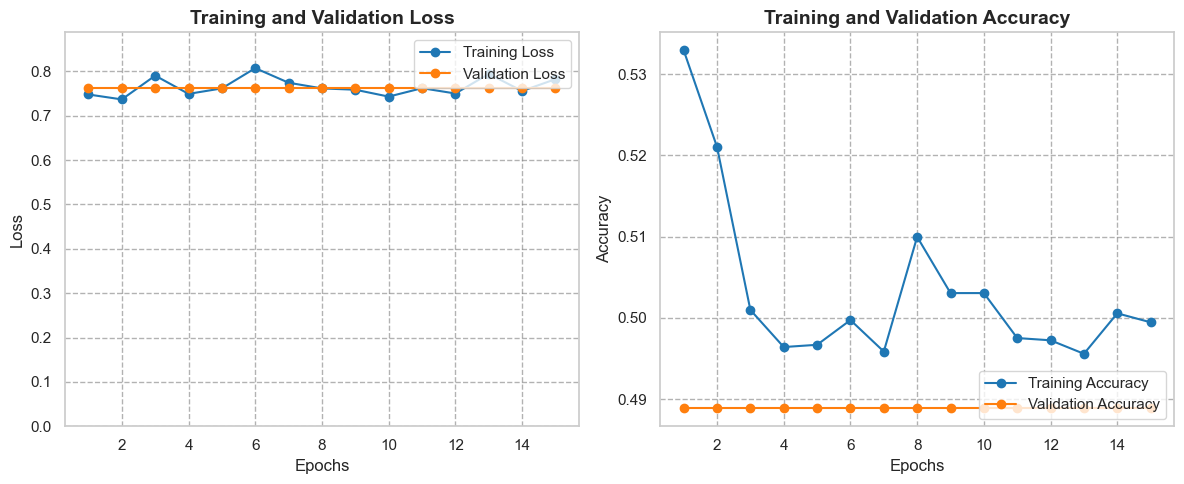

In [28]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=15)

Test Loss: 0.7675, Test Accuracy: 0.4816
Confusion Matrix:
[[  0 536]
 [  0 498]]


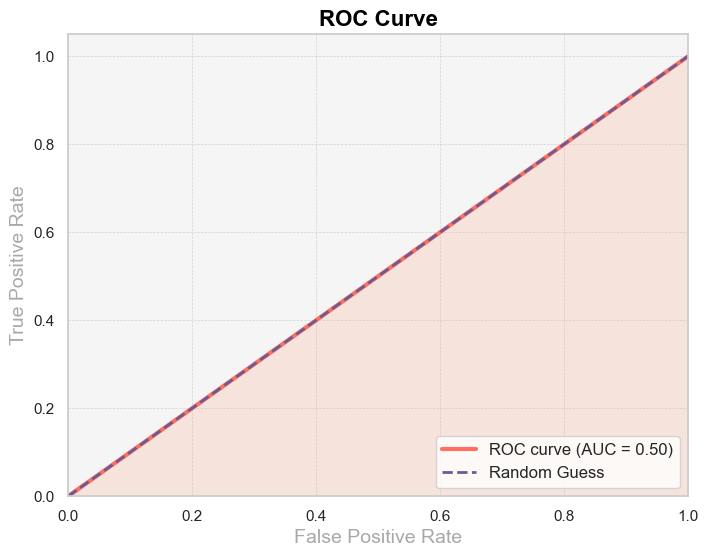

In [29]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

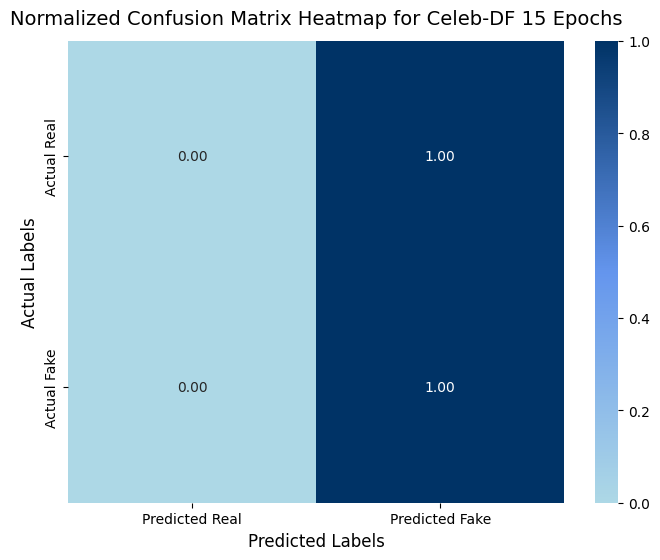

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[0, 536],  # Actual Real
                               [0, 498]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from dark green to sage green
cmap = LinearSegmentedColormap.from_list("custom_blue", ["#add8e6", "cornflowerblue", "#003366"])  # Light to dark blue

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Celeb-DF 15 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 15 epc, lr = 0.0001

In [ ]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=15):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [11]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=15):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [12]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [13]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# Run training for 15 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=15)

Epoch 1/15, Train Loss: 0.3768, Train Accuracy: 0.8260
Epoch 2/15, Train Loss: 0.1873, Train Accuracy: 0.9250
Epoch 3/15, Train Loss: 0.1357, Train Accuracy: 0.9493
Epoch 4/15, Train Loss: 0.0959, Train Accuracy: 0.9654
Epoch 5/15, Train Loss: 0.0664, Train Accuracy: 0.9781
Epoch 6/15, Train Loss: 0.0539, Train Accuracy: 0.9826
Epoch 7/15, Train Loss: 0.0502, Train Accuracy: 0.9833
Epoch 8/15, Train Loss: 0.0367, Train Accuracy: 0.9878
Epoch 9/15, Train Loss: 0.0436, Train Accuracy: 0.9857
Epoch 10/15, Train Loss: 0.0380, Train Accuracy: 0.9878
Epoch 11/15, Train Loss: 0.0330, Train Accuracy: 0.9893
Epoch 12/15, Train Loss: 0.0318, Train Accuracy: 0.9900
Epoch 13/15, Train Loss: 0.0238, Train Accuracy: 0.9927
Epoch 14/15, Train Loss: 0.0314, Train Accuracy: 0.9907
Epoch 15/15, Train Loss: 0.0366, Train Accuracy: 0.9877
Training complete.


In [ ]:
# Run validation for 15 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=15)

Epoch 1/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 2/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 3/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 4/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 5/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 6/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 7/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 8/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 9/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 10/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 11/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 12/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 13/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 14/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Epoch 15/15, Validation Loss: 0.0281, Validation Accuracy: 0.9889
Validation complete

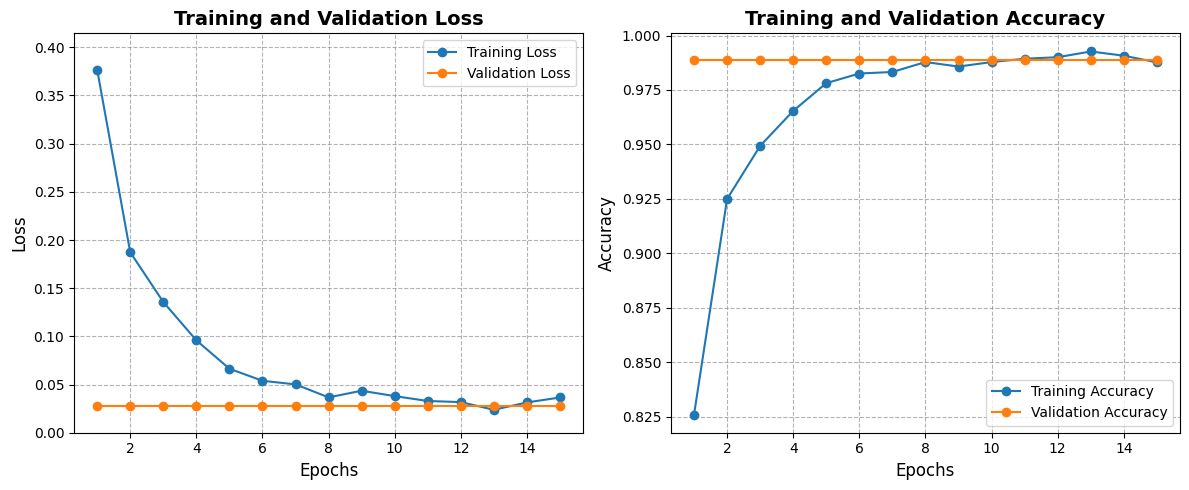

In [18]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=15)

Test Loss: 0.0232, Test Accuracy: 0.9913
Confusion Matrix:
[[522   0]
 [  9 503]]


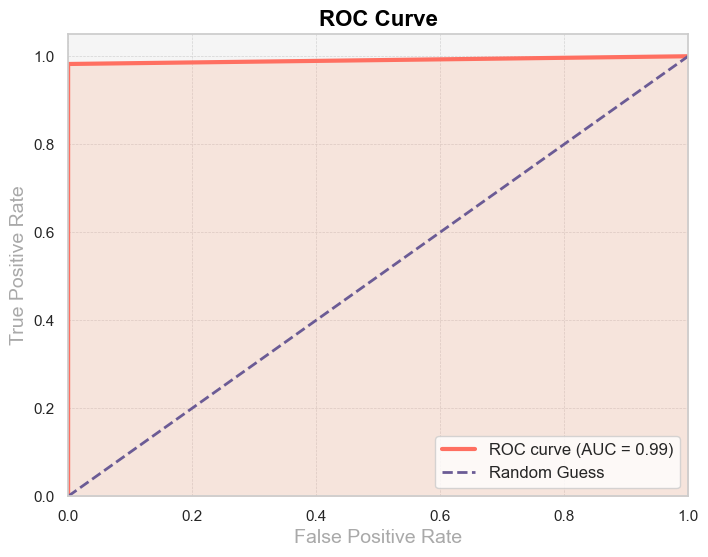

In [19]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

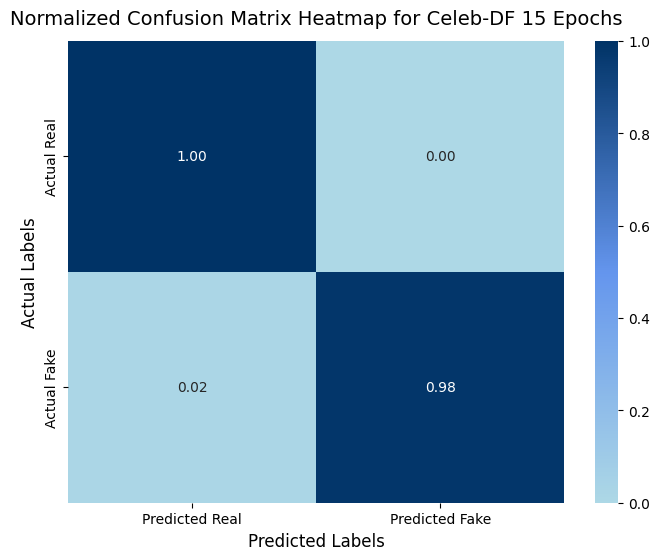

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[522, 0],  # Actual Real
                               [9, 503]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from dark green to sage green
cmap = LinearSegmentedColormap.from_list("custom_blue", ["#add8e6", "cornflowerblue", "#003366"])  # Light to dark blue

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Celeb-DF 15 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()

## 20 epc, lr = 0.01

In [31]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [32]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=20):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [33]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=20):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [34]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [35]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [36]:
# Run training for 20 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=20)

Epoch 1/20, Train Loss: 0.7691, Train Accuracy: 0.5203
Epoch 2/20, Train Loss: 0.7593, Train Accuracy: 0.5149
Epoch 3/20, Train Loss: 0.7661, Train Accuracy: 0.5050
Epoch 4/20, Train Loss: 0.7737, Train Accuracy: 0.4981
Epoch 5/20, Train Loss: 0.7680, Train Accuracy: 0.4986
Epoch 6/20, Train Loss: 0.7592, Train Accuracy: 0.5029
Epoch 7/20, Train Loss: 0.7560, Train Accuracy: 0.4931
Epoch 8/20, Train Loss: 0.7758, Train Accuracy: 0.5075
Epoch 9/20, Train Loss: 0.7606, Train Accuracy: 0.4997
Epoch 10/20, Train Loss: 0.7802, Train Accuracy: 0.5044
Epoch 11/20, Train Loss: 0.7607, Train Accuracy: 0.4956
Epoch 12/20, Train Loss: 0.7672, Train Accuracy: 0.4970
Epoch 13/20, Train Loss: 0.7953, Train Accuracy: 0.5071
Epoch 14/20, Train Loss: 0.7507, Train Accuracy: 0.4909
Epoch 15/20, Train Loss: 0.7741, Train Accuracy: 0.5018
Epoch 16/20, Train Loss: 0.7533, Train Accuracy: 0.5105
Epoch 17/20, Train Loss: 0.7612, Train Accuracy: 0.5008
Epoch 18/20, Train Loss: 0.7617, Train Accuracy: 0.4920
E

In [37]:
# Run validation for 20 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=20)

Epoch 1/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 2/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 3/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 4/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 5/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 6/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 7/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 8/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 9/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 10/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 11/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 12/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 13/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 14/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 15/20, Validation Loss: 0.8467, Validation Accuracy: 0.5111
Epoch 16/20, Valida

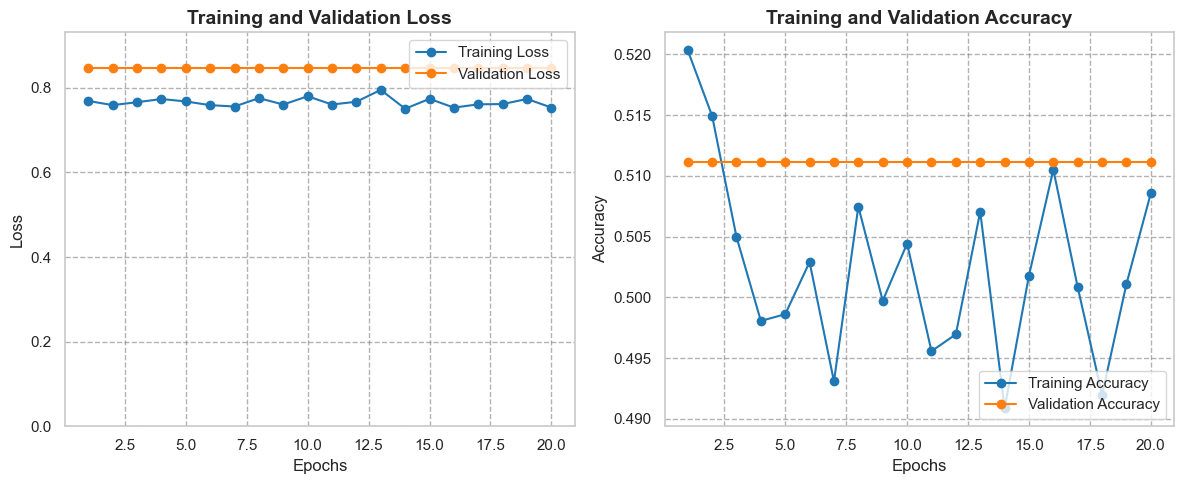

In [38]:
# Assuming you have the lists of losses and accuracies from training/validation
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, num_epoch=20)

Test Loss: 0.8382, Test Accuracy: 0.5184
Confusion Matrix:
[[536   0]
 [498   0]]


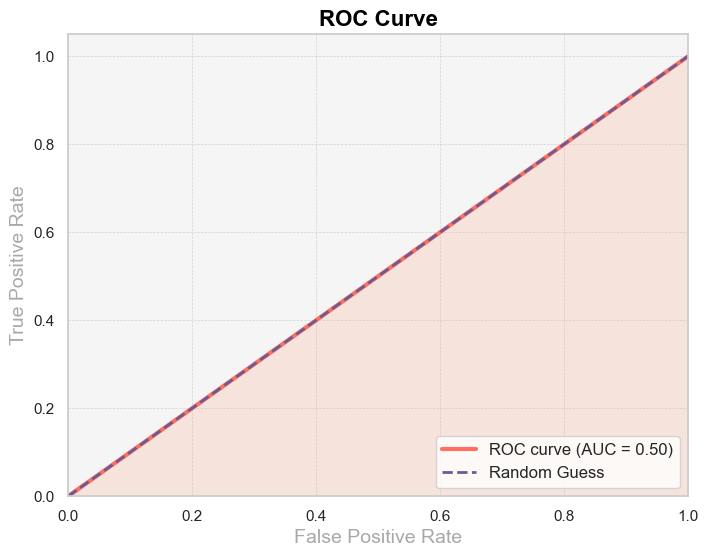

In [39]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

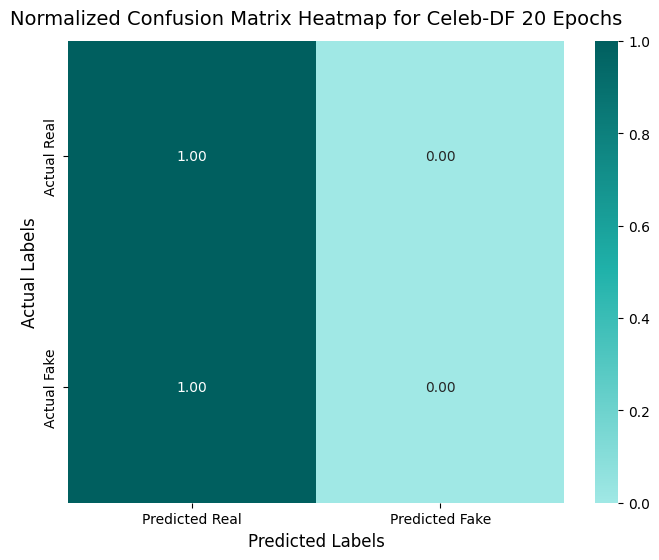

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[536, 0],  # Actual Real
                               [498, 0]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from dark green to sage green
cmap = LinearSegmentedColormap.from_list("custom_lightseagreen", ["#a0e8e5", "lightseagreen", "#005f5f"])  # Light to dark lightseagreen

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Celeb-DF 20 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()


## 20 epc, lr = 0.0001

In [21]:
# Initialize lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [22]:
# Define the training function (for training only)
def train_model(model, train_loader, criterion, optimizer, device, num_epoch=20):
    model.train()  # Set the model to training mode
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass

            optimizer.step()  # Optimizer step

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for training
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    print('Training complete.')
    return train_losses, train_accuracies


In [23]:
# Define the validation function (for validation only)
def validate_model(model, val_loader, criterion, device, num_epoch=20):
    model.eval() # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute the epoch loss and accuracy for validation
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for each epoch
        print(f'Epoch {epoch+1}/{num_epoch}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    print('Validation complete.')
    return val_losses, val_accuracies


In [24]:
# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Prediction and accuracy calculations
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Storing labels and predictions for further evaluation (confusion matrix and ROC)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve and AUC Calculation
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Create a refined ROC curve plot with the new color scheme
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Define new pastel colors that are more vivid and easy to read
    pastel_curve = "#FF6F61"  # Soft coral for ROC curve
    random_guess = "#6B5B95"  # Muted purple for the diagonal line
    fill_color = "#FFA07A"    # Light salmon for fill

    # Plot ROC curve and diagonal for reference
    plt.plot(fpr, tpr, color=pastel_curve, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=random_guess, lw=2, linestyle='--', label='Random Guess')
    
    # Add semi-transparent fill for emphasis
    plt.fill_between(fpr, tpr, color=fill_color, alpha=0.2)

    # Set axis limits and labels with dark gray color
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, color='darkgray')
    plt.ylabel('True Positive Rate', fontsize=14, color='darkgray')
    
    # Set title with black color
    plt.title('ROC Curve', fontsize=16, weight='bold', color='black')
    plt.legend(loc="lower right", fontsize=12)
    
    # Add gridlines and use a neutral background
    plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('whitesmoke')

    # Display the ROC curve
    plt.show()

    return test_loss, test_acc


In [ ]:
# Create the model instance
model = DeepFakeDetectionModel(num_classes=2)
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/faishalkamil/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [27]:
# Run training for 20 epochs
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epoch=20)

Epoch 1/20, Train Loss: 0.3893, Train Accuracy: 0.8187
Epoch 2/20, Train Loss: 0.1676, Train Accuracy: 0.9404
Epoch 3/20, Train Loss: 0.1180, Train Accuracy: 0.9590
Epoch 4/20, Train Loss: 0.0704, Train Accuracy: 0.9759
Epoch 5/20, Train Loss: 0.0677, Train Accuracy: 0.9747
Epoch 6/20, Train Loss: 0.0378, Train Accuracy: 0.9862
Epoch 7/20, Train Loss: 0.0484, Train Accuracy: 0.9839
Epoch 8/20, Train Loss: 0.0360, Train Accuracy: 0.9877
Epoch 9/20, Train Loss: 0.0379, Train Accuracy: 0.9880
Epoch 10/20, Train Loss: 0.0269, Train Accuracy: 0.9914
Epoch 11/20, Train Loss: 0.0233, Train Accuracy: 0.9925
Epoch 12/20, Train Loss: 0.0306, Train Accuracy: 0.9899
Epoch 13/20, Train Loss: 0.0212, Train Accuracy: 0.9932
Epoch 14/20, Train Loss: 0.0169, Train Accuracy: 0.9943
Epoch 15/20, Train Loss: 0.0193, Train Accuracy: 0.9956
Epoch 16/20, Train Loss: 0.0379, Train Accuracy: 0.9866
Epoch 17/20, Train Loss: 0.0096, Train Accuracy: 0.9971
Epoch 18/20, Train Loss: 0.0240, Train Accuracy: 0.9916
E

In [28]:
# Run validation for 20 epochs (this can be run separately at a different time if needed)
val_losses, val_accuracies = validate_model(model, val_loader, criterion, device, num_epoch=20)

Epoch 1/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 2/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 3/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 4/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 5/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 6/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 7/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 8/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 9/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 10/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 11/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 12/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 13/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 14/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 15/20, Validation Loss: 0.0087, Validation Accuracy: 0.9981
Epoch 16/20, Valida

Test Loss: 0.0065, Test Accuracy: 0.9990
Confusion Matrix:
[[521   1]
 [  0 512]]


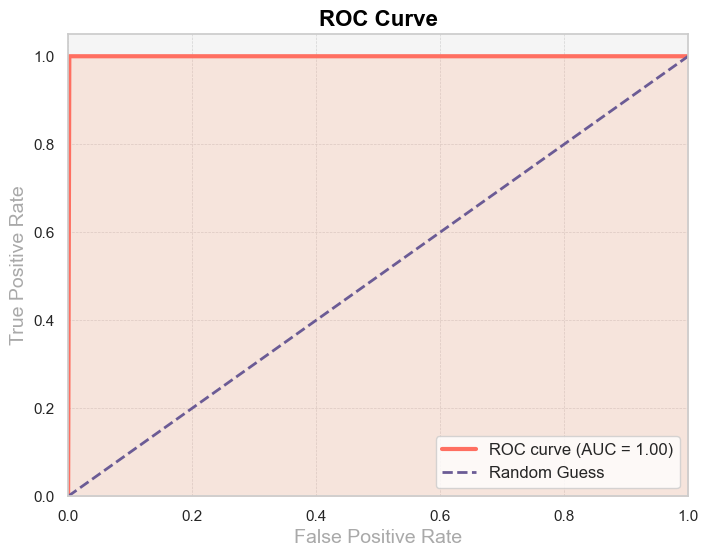

In [29]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)

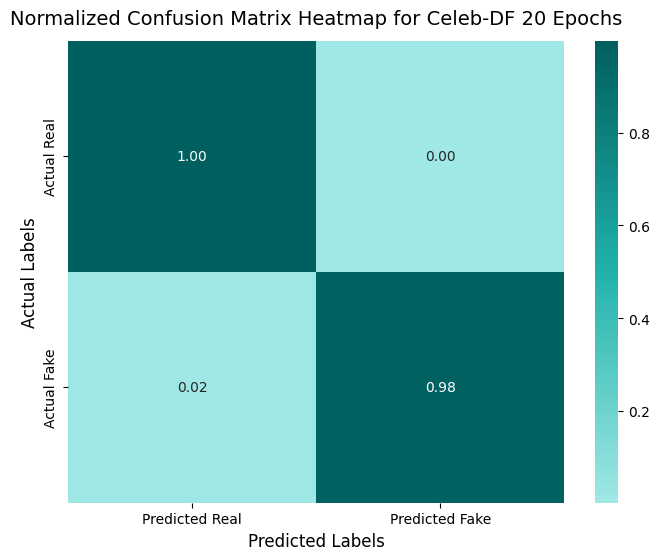

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Your confusion matrix
conf_matrix_value = np.array([[521, 1],  # Actual Real
                               [9, 512]]) # Actual Fake

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_value.astype('float') / conf_matrix_value.sum(axis=1)[:, np.newaxis]

# Create a custom colormap that transitions from dark green to sage green
cmap = LinearSegmentedColormap.from_list("custom_lightseagreen", ["#a0e8e5", "lightseagreen", "#005f5f"])  # Light to dark lightseagreen

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, cbar=True,
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])

# Set the title and labels
plt.title('Normalized Confusion Matrix Heatmap for Celeb-DF 20 Epochs', fontsize=14, pad = 12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)

# Show the plot
plt.show()